In this covariance computation we compute **$\Delta P_k$ within the intersection of the boundaries of the linear matter power spectrum and non-linear (extended) emulator** (small range) **and with HALOFIT** where we are extrapolating.

This would be the equivalent to the case we produce a theoretical covariance for baccoemu (emulator vs truth) and used the Delta Pk of the simulations.

In [2]:
import baccoemu
import numpy as np
import pickle
import sacc
import pyccl as ccl
import tools
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import os
import pyccl as ccl
import getdist
from getdist import plots

# Generate the data

In [3]:
nonlinear_emu_path='/mnt/zfsusers/gravityls_3/codes/NN_emulator_PCA6_0.95_300_400n_paired_comb'
nonlinear_emu_details='details.pickle'

mpk_emulator = baccoemu.Matter_powerspectrum(nonlinear_emu_path=nonlinear_emu_path,
                                            nonlinear_emu_details=nonlinear_emu_details)

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/thcov/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
for emu in ['linear', 'nonlinear']:
    print(emu)
    for key, bound in zip(mpk_emulator.emulator[emu]['keys'], mpk_emulator.emulator[emu]['bounds']):
        print(key, bound)
    print()
    

linear
omega_cold [0.06 0.7 ]
omega_baryon [0.03 0.07]
hubble [0.5 0.9]
neutrino_mass [0. 1.]
w0 [-2.  -0.5]
wa [-0.5  0.5]
expfactor [0.1 1. ]

nonlinear
omega_cold [0.15 0.47]
sigma8_cold [0.4  1.15]
omega_baryon [0.03 0.07]
ns [0.83 1.1 ]
hubble [0.5 0.9]
neutrino_mass [0.  0.4]
w0 [-1.4 -0.6]
wa [-0.5  0.5]
expfactor [0.275 1.1  ]



In [5]:
# Get k array [h/Mpc]
k = mpk_emulator.emulator['nonlinear']['k'].copy()

fload = tools.get_lhc_priors_range(k)

pk_lin_ccl = fload['pk_lin']
pk_nonlin_ccl = fload['pk_nonlin']
H = fload['lhc']
params = fload['params']
skip_index = fload['skip_index']
k = fload['k_hMpc']

params_lhc = {k: H[:, i] for i, k in enumerate(params)}
samples = H.shape[0]
params_lhc['w0'] = -np.ones(samples)
params_lhc['wa'] = np.zeros(samples)



priors = {'A_sE9': [0.5, 5],
          'Omega_m': [0.1, 0.7],
          'Omega_b': [0.03, 0.07],
          'h': [0.55, 0.91],
          'n_s': [0.87, 1.07],
          'm_nu': [0.0559, 0.400],
          'expfactor': [0.275, 1]}
limits = np.array([priors[param] for param in params])
print(f'Density of points = {samples / np.prod(np.diff(limits, axis=1)):g}')

Density of points = 1.03098e+07


Removed no burn in


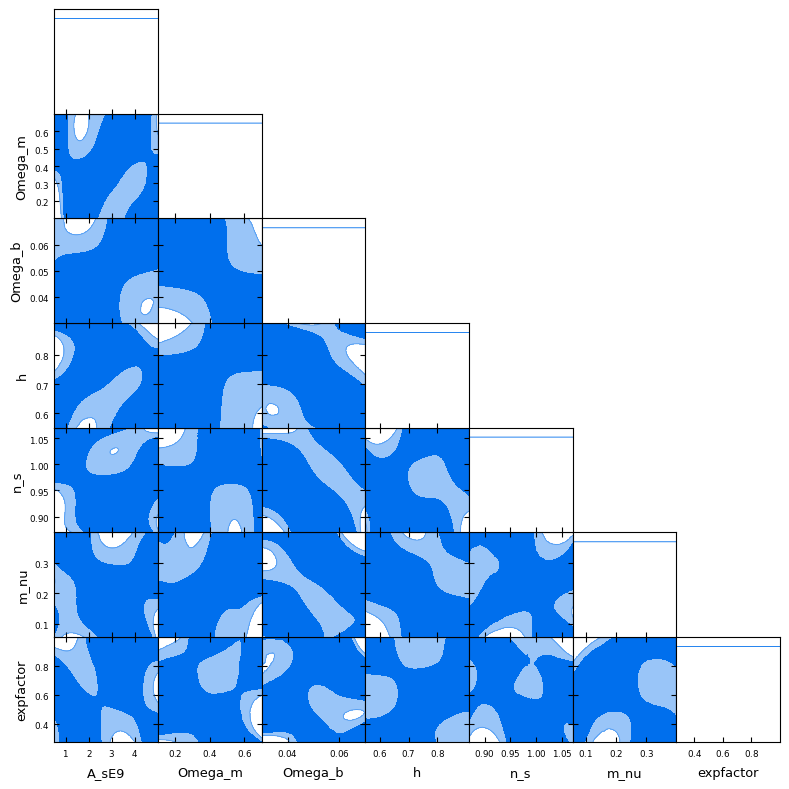

In [6]:
# From tools.py
MCSamples = getdist.MCSamples(samples=H,
                            names=params,
                            #labels=['S_8', '\Omega_{\rm m}', '\sigma_8'],
                            sampler='nested', ranges=priors)

g = getdist.plots.get_subplot_plotter(width_inch=8)
g.triangle_plot(MCSamples, params, filled=True)

Removed no burn in


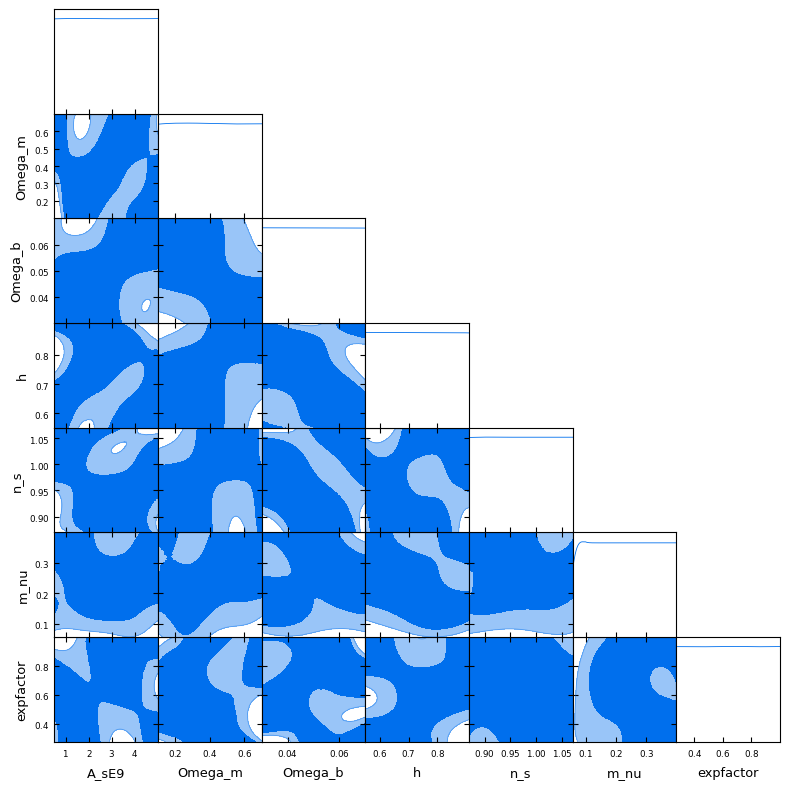

In [7]:
# Create the arrays for this run
params_bacco, sel = tools.get_params_inbounds_of_baccoemu(params_lhc, emulator='nonlinear', mpk_emulator=mpk_emulator)
params_halofit = {p: params_lhc[p][~sel] for p in params}

pk_lin_total = np.zeros((samples, k.size))
pk_nonlin_total = np.zeros((samples, k.size))

# Add baccoemu part (only the nonlinear, as we use CCL for the linear in the MCMC)
# _, pk_lin_total[sel] = mpk_emulator.get_linear_pk(k=k, cold=False, **params_bacco) 
_, pk_nonlin_total[sel] = mpk_emulator.get_nonlinear_pk(k=k, cold=False, **params_bacco)

# Add HALOFIT part
# pk_lin_total[~sel] = pk_lin_ccl[~sel]
pk_lin_total = pk_lin_ccl.copy()
pk_nonlin_total[~sel] = pk_nonlin_ccl[~sel]

# Remove failed params
mask = np.ones(samples, dtype=bool)
mask[skip_index] = False  # We remove the failed CCL runs
mask[sel] = True  # but not those that were computed with baccoemu 

samples = np.sum(mask)
pk_lin_total = pk_lin_total[mask]
pk_nonlin_total = pk_nonlin_total[mask]




# From tools.py
MCSamples = getdist.MCSamples(samples=H[mask],
                            names=params,
                            #labels=['S_8', '\Omega_{\rm m}', '\sigma_8'],
                            sampler='nested', ranges=priors)

g = getdist.plots.get_subplot_plotter(width_inch=8)
g.triangle_plot(MCSamples, params, filled=True)

# Do PCA in Mpc

In [8]:
# Transform the data from h/Mpc to 1/Mpc
# h/Mpc -> 1/Mpc
h = params_lhc['h'][mask]
kMpc = k[:, None] * h 
kMpc = kMpc.T
print(kMpc.shape)

# Create a common set of k values in [1/Mpc]
kMpc_common = np.logspace(np.log10(kMpc[:, 0].max()+1e-6), np.log10(kMpc[:, -1].min()), 174)

# Pk [Mpc/h]^3 -> [Mpc]^3
delta_p = pk_nonlin_total - pk_lin_total
delta_p_Mpc3 = delta_p / h[:, None]**3
delta_p_Mpc3_common = np.zeros((samples, kMpc_common.size))

# Interpolate the data and evaluate it in the common values of k [1/Mpc].
# Note that because delta_p can be negative, we don't use the logarithm
for i in range(samples):
    delta_p_Mpc3_common[i, :] = interp1d(np.log(kMpc[i]), delta_p_Mpc3[i])(np.log(kMpc_common))
    
# Therefore, the variables to use are:
# kMpc_common, delta_p_Mpc3_common

print(delta_p_Mpc3_common.shape)

(19873, 174)
(19873, 174)


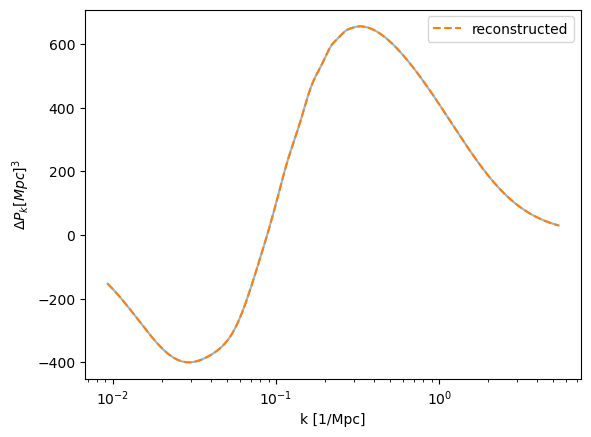

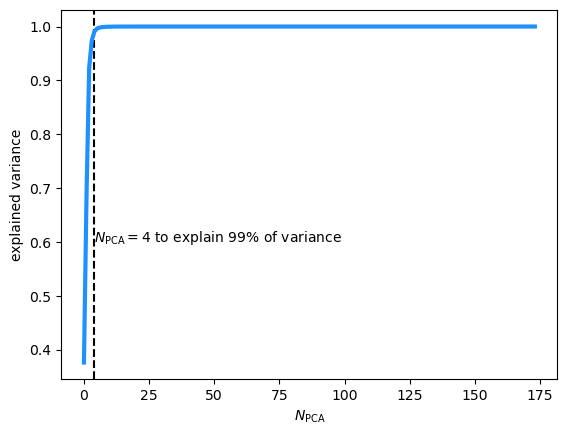

In [9]:
# Decompose delta_p_Mpc3_common in PCA

delta_p = delta_p_Mpc3_common
data_mean = np.mean(delta_p, axis=0)
data_std = np.std(delta_p, axis=0)

# First standarize the data
standarized_data = (delta_p - data_mean) / data_std
# Find the eigenvalues and eigenvectors
evk, vk = np.linalg.eigh(np.cov(standarized_data.T))
# Order the eigenvectors and eigenvalues in decreasing order
sorted_indices = np.argsort(evk)[::-1]
evk = evk[sorted_indices]
vk = vk[:, sorted_indices]

for N in range(evk.size):
    reduced_data = np.matmul(standarized_data, vk[:, :N]) # transform the original data
    reconstructed = data_std * np.matmul(reduced_data, vk[:, :N].T) + data_mean
    rdev = reconstructed / delta_p - 1
    if np.abs(rdev).max() < 0.01:
        print('Precision in the reconstructed delta_p achieved at N =', N)
        break

plt.semilogx(kMpc_common, delta_p[0], alpha=0.5)
plt.semilogx(kMpc_common, reconstructed[0], ls='--', label='reconstructed')
plt.xlabel('k [1/Mpc]')
plt.ylabel('$\Delta P_k [Mpc]^3$')
plt.legend()
plt.show()
plt.close()

# use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
explained_variance = evk / np.sum(evk)

fix, ax = plt.subplots(1, 1)
index = np.where(np.cumsum(explained_variance) >= 0.99)[0][0]
# print(r'$N_{{\rm PCA}} = {}$ to explain 99% of variance'.format(index))
ax.axvline(index, color='k', ls='--')
ax.plot(np.cumsum(explained_variance), lw=3, color='dodgerblue')
ax.set_xlabel(r'$N_{\rm PCA}$')
ax.set_ylabel(r'explained variance')
ax.text(index, 0.6, r'$N_{{\rm PCA}} = {}$ to explain 99% of variance'.format(index))
plt.show()

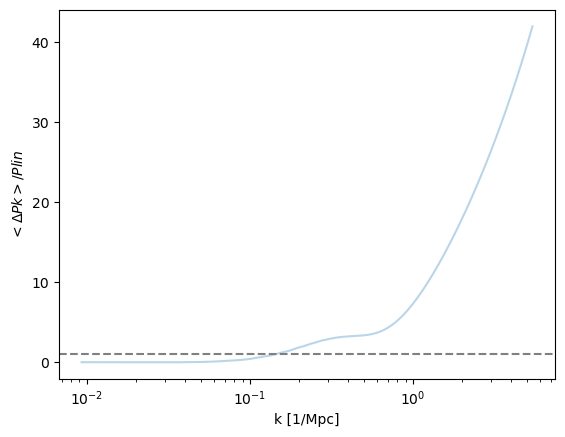

In [10]:
# Plot the components of standarized variable Sk (see notes)
pklin = pk_lin_total[0] / h[0]**3

plt.semilogx(kMpc_common, data_mean/pklin, alpha=0.3)
plt.axhline(1, ls='--', color='gray')
plt.xlabel('k [1/Mpc]')
plt.ylabel('$<\Delta Pk>/Plin $')
plt.show()
plt.close()

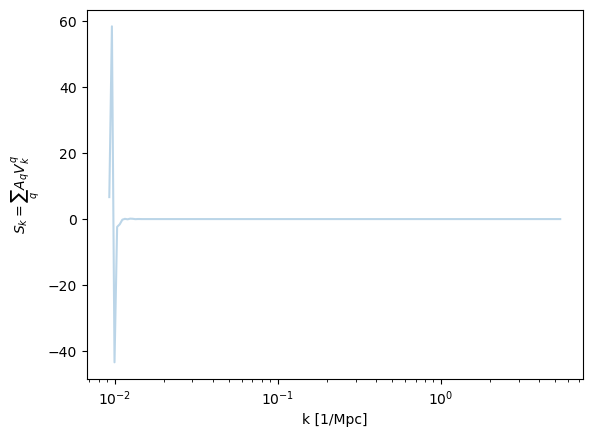

In [11]:
# Plot the components of standarized variable Sk (see notes)
plt.semilogx(kMpc_common, np.sum(evk*vk.T, axis=0), alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$S_k = \sum_q A_q V^q_k$')
plt.show()
plt.close()

In [12]:
# Plot the components of standarized variable Sk (see notes)
for i in range(index):
    plt.semilogx(kMpc_common, evk[i]*vk[:, i], alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$A_q V^q_k$')
plt.show()
plt.close()

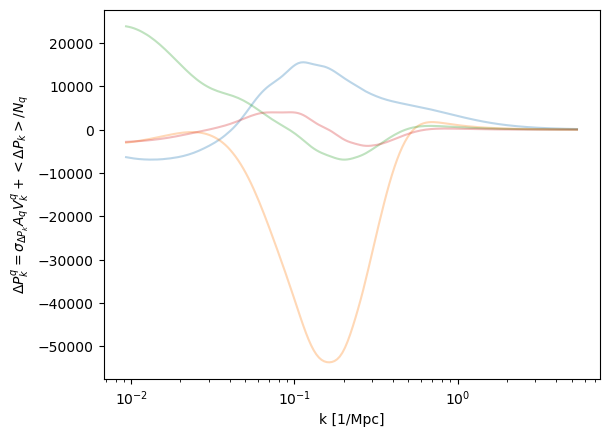

In [13]:
# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk = data_std * evk[i] * vk[:, i] + data_mean / index
    plt.semilogx(kMpc_common, DeltaPk, alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$\Delta P_k^q = \sigma_{\Delta P_k} A_q V^q_k + <\Delta P_k> / N_q$')
plt.show()
plt.close()

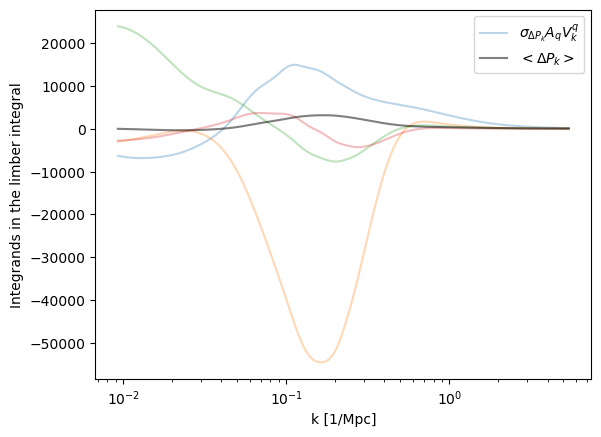

In [14]:
# But, actually, we probably don't want to integrate that quantity directly.
# Instead, we should integrate data_std * evk[i] * vk[:, i], and data_mean separately.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')
plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

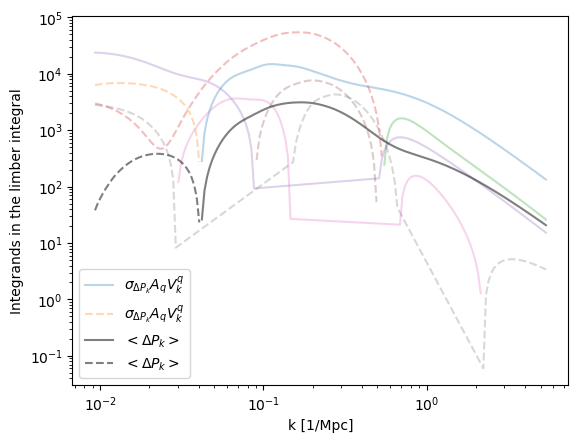

In [15]:
# But, actually, we probably don't want to integrate that quantity directly.
# Instead, we should integrate data_std * evk[i] * vk[:, i], and data_mean separately.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common[DeltaPk_part1>0], DeltaPk_part1[DeltaPk_part1>0], alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')
    plt.semilogx(kMpc_common[DeltaPk_part1<0], -DeltaPk_part1[DeltaPk_part1<0], alpha=0.3, ls='--',
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')

plt.loglog(kMpc_common[data_mean>0], data_mean[data_mean>0], color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.loglog(kMpc_common[data_mean<0], -data_mean[data_mean<0], color='k', alpha=0.5, ls='--', label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

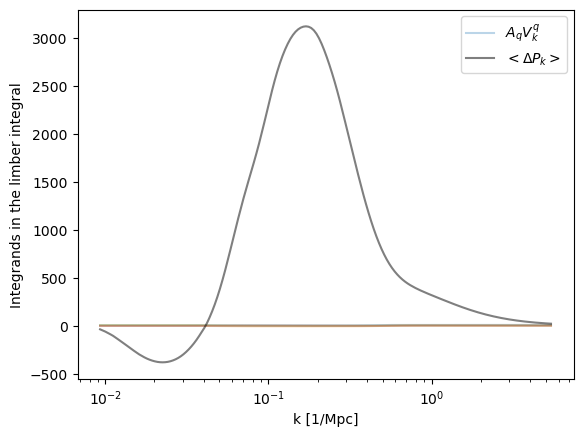

In [16]:
# Even better, we can integrate evk[i] * vk[:, i], first, and then multiply it by data_std

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$A_q V^q_k$' if i ==0 else '')
plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

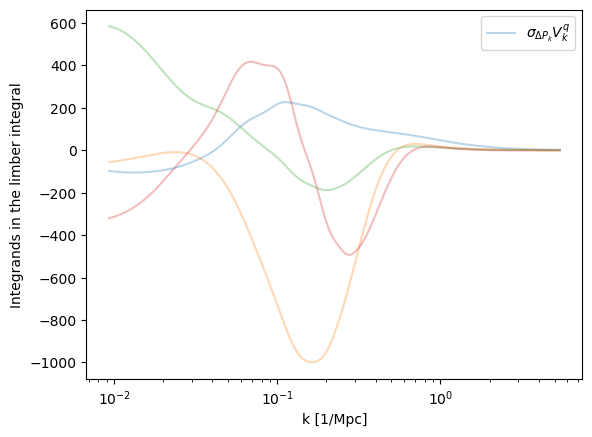

In [17]:
# Actually, I need to multiply vk[:, i] by data_std before doing the limber integral
# because data_std is a vector on k.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} V^q_k$' if i ==0 else '')
# plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

# Generate covariance

In [18]:
s = sacc.Sacc.load_fits('../data/cls_cov_GNG.fits')
s.keep_selection(data_type='cl_ee')

# Redshift shifts
dz_shifts = {'DESY3wl__0': 0,
             'DESY3wl__1': 0,
             'DESY3wl__2': 0, 
             'DESY3wl__3': 0,
            }

# Multiplicative bias
m_wl = {'DESY3wl__0': -0.0063,
         'DESY3wl__1': -0.0198,
         'DESY3wl__2': -0.0241, 
         'DESY3wl__3': -0.0369,
        }
m_wl = dz_shifts.copy()


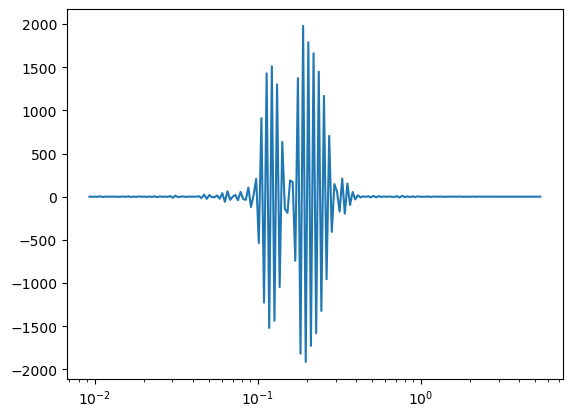

In [19]:
# Generate the ccl.Pk2D object, assuming a  constant error Delta Pk accross redshift
a_arr = np.linspace(1, 1/(1+3), 20)[::-1]
ones = np.ones_like(a_arr)
vk_x_data_std_pk2d = []

# Iterate over the eigenvectors to get the Pk2D objects
# We need to multiply the eigenvectors by data_std to do the integrals properly
for vki in vk.T:
    pk_arr = data_std[:, None] * vki[:, None] * ones
    vk_x_data_std_pk2d.append(ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False))
    
# Get the Pk2D object for the data mean
pk_arr = data_mean[:, None] * ones
data_mean_pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False, extrap_order_lok=0, extrap_order_hik=0)

# a = params_lhc['expfactor'][mask]
# abins = np.linspace(0.25, 1, 20)
# a_eff = []
# data_mean_abins = []
# for i in range(abins.size-1):
#     amin = abins[i]
#     amax = abins[i+1]
#     sel = (a >= amin) * (a < amax)
#     a_eff.append(np.mean(a[sel]))
#     dmean = np.mean(delta_p[sel], axis=0)
#     data_mean_abins.append(dmean)
# a_eff = np.array(a_eff)
# data_mean_abins = np.array(data_mean_abins)
# data_mean_pk2d = ccl.Pk2D(a_arr=a_eff, lk_arr=np.log(kMpc_common), pk_arr=data_mean_abins, is_logp=False, extrap_order_lok=0, extrap_order_hik=0)

pk_arr = np.array([data_mean_pk2d(kMpc_common, ai, cosmo=ccl.CosmologyVanillaLCDM()) for ai in a_arr])
data_mean_pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr, is_logp=False, extrap_order_lok=0, extrap_order_hik=0)


# Check the interpolation
karr = np.logspace(-7, 2, 100)
plt.semilogx(kMpc_common, data_mean, color='k')
for ai in [0.26, 0.4, 0.7, 0.8, 1]:
    plt.semilogx(karr, data_mean_pk2d(karr, ai))
plt.show()
plt.close()

# Check the interpolation
plt.semilogx(kMpc_common, data_std * vki)
# plt.semilogx(kMpc_common, vk_x_data_std_pk2d[-1](kMpc_common, 0.26), ls='--')
plt.show()
plt.close()

## DESY3__3 only

Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__3', 'DESY3wl__3')
Projecting eigenvector number = 0
Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Computing covariance matrix


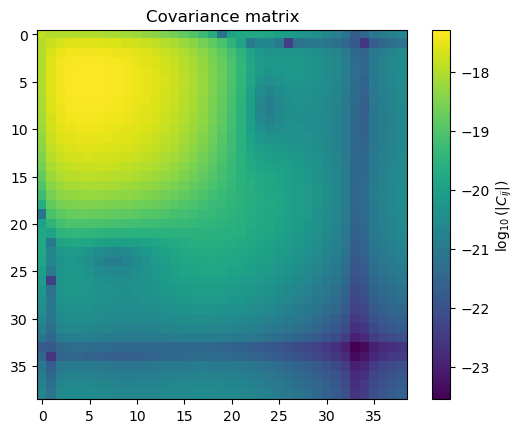

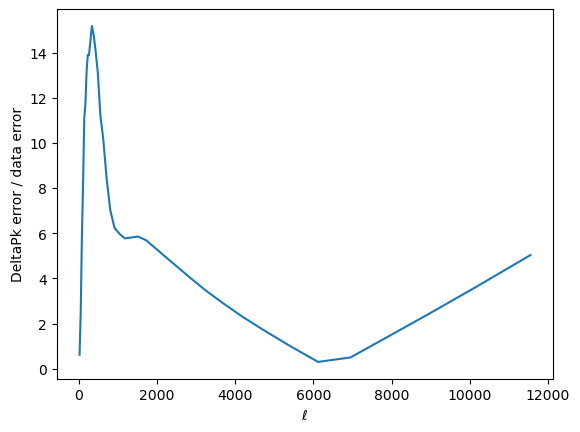

In [24]:
s1 = s.copy()
# For the test, lest keep only one tracer
s1.keep_tracers(['DESY3wl__3'])

N = index # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None
snew, scorr, wl  = tools.get_sacc_th_marg(s1, evk=evk[:N], vk_x_data_std_pk2d=vk_x_data_std_pk2d[:N],
                                          data_mean_pk2d=data_mean_pk2d,
                                          dz_shifts=dz_shifts,
                                          m_wl=m_wl,
                                          vk_sigma=vk_sigma)
mean_correction = scorr.mean
cov = scorr.covariance.covmat

# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

# Plot the error from the DeltaPk covariance respect to the value of the data error
plt.plot(ell, np.sqrt(np.diag(cov))/err)
plt.xlabel('$\ell$')
plt.ylabel('DeltaPk error / data error')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__3', 'DESY3wl__3'][i], alpha=0.3, label='$w_\ell^q$' if i==0 else '')
plt.semilogx(ell, mean_correction, color='blue', label='Mean')

wlfinal = np.sum(wl['DESY3wl__3', 'DESY3wl__3'], axis=0)
plt.semilogx(ell, wlfinal, color='k', label='Total contribution')
plt.errorbar(ell, cl, yerr=err, color='k', fmt='.')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()

In [20]:
# Check correction on the data Cell
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
ell, cl2, cl_cov2 = snew.get_ell_cl('cl_ee', 'DESY3wl__3', 'DESY3wl__3', return_cov=True)
plt.errorbar(ell, cl, yerr=np.sqrt(np.diag(cl_cov)), fmt='.', label='Data')
plt.errorbar(ell, cl2, yerr=np.sqrt(np.diag(cl_cov2)), fmt='.', label='Data - correction')



cosmo = ccl.CosmologyVanillaLCDM()
tracer = s.tracers['DESY3wl__3']
ccl_tracer = ccl.WeakLensingTracer(cosmo, dndz=(tracer.z, tracer.nz), has_shear=True, ia_bias=None)
ix = s.indices(tracers=('DESY3wl__3', 'DESY3wl__3'))
bpw = s.get_bandpower_windows(ix)
cl = (1+m_wl['DESY3wl__3']) * (1+m_wl['DESY3wl__3']) * ccl.angular_cl(cosmo, ccl_tracer, ccl_tracer, bpw.values)
cl_bin= bpw.weight.T.dot(cl)
plt.errorbar(ell, cl_bin, fmt='x', label='Halofit')


cosmo = ccl.CosmologyVanillaLCDM(matter_power_spectrum='linear')
tracer = s.tracers['DESY3wl__3']
ccl_tracer = ccl.WeakLensingTracer(cosmo, dndz=(tracer.z, tracer.nz), has_shear=True, ia_bias=None)
ix = s.indices(tracers=('DESY3wl__3', 'DESY3wl__3'))
bpw = s.get_bandpower_windows(ix)
cl = (1+m_wl['DESY3wl__3']) * (1+m_wl['DESY3wl__3']) * ccl.angular_cl(cosmo, ccl_tracer, ccl_tracer, bpw.values)
cl_bin= bpw.weight.T.dot(cl)
plt.errorbar(ell, cl_bin, fmt='x', label='Linear')


plt.semilogx(ell,mean_correction, color='black', label='Mean')
plt.semilogx(ell,-mean_correction, color='black', ls='--')

cl = (1+m_wl['DESY3wl__3']) * (1+m_wl['DESY3wl__3']) * ccl.angular_cl(cosmo, ccl_tracer, ccl_tracer, bpw.values, p_of_k_a=data_mean_pk2d, limber_integration_method="spline")
cl_bin= bpw.weight.T.dot(cl)
plt.semilogx(ell, cl_bin, color='purple', label='Mean (By hand)')
plt.semilogx(ell, -cl_bin, color='purple', ls=':')



plt.xlabel('$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

## All DESY3wl

Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__0')
Projecting eigenvector number = 0
Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__1')
Projecting eigenvector number = 0
Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__2')
Projecting eigenvector number = 0
Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__3')
Projecting eigenvector number = 0
Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting for tracer combination ('DESY3wl_

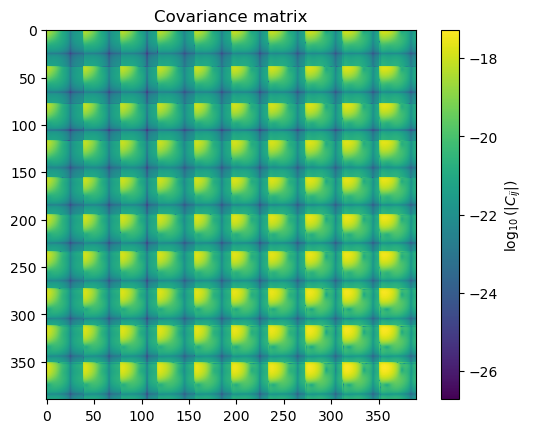

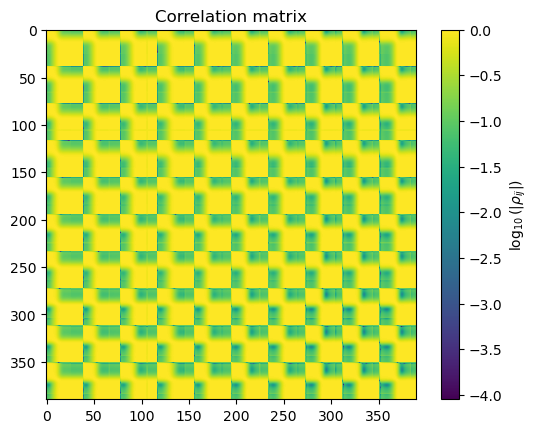

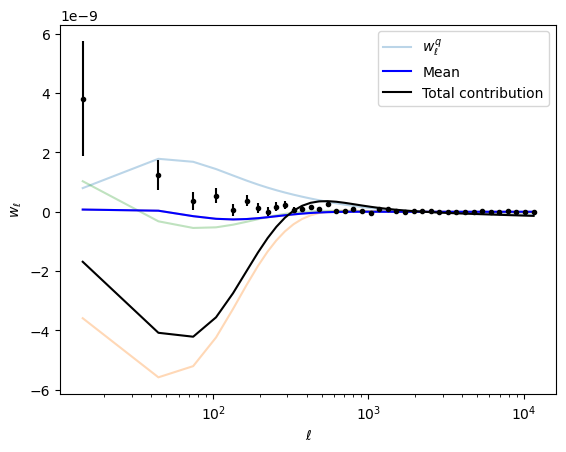

In [33]:
s1 = s.copy()

N = index # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None
snew, scorr, wl  = tools.get_sacc_th_marg(s1, evk=evk[:N], vk_x_data_std_pk2d=vk_x_data_std_pk2d[:N],
                                          data_mean_pk2d=data_mean_pk2d,
                                          dz_shifts=dz_shifts,
                                          m_wl=m_wl,
                                          vk_sigma=vk_sigma)
mean_correction = scorr.mean
cov = scorr.covariance.covmat
        
# Save the sacc file with this contribution added up
fname = "../data/cls_cov_GNG_thcov_Cellcorrected_LinNonlin_PriorsRange.sacc"
if not os.path.isfile(fname):
    print(f"Saving the sacc file with the covariance added into {fname}", flush=True)
    snew.save_fits(fname)
else:
    print(f"{fname} already exists. Not saving the new one.", flush=True)

# Save the sacc file with this contribution added up
fname = "../data/cls_correction_thcov_LinNonlin_PriorsRange.sacc"
if not os.path.isfile(fname):
    print(f"Saving the sacc file with the Cell correction and theory covariance into {fname}", flush=True)
    scorr.save_fits(fname)
else:
    print(f"{fname} already exists. Not saving the new one.", flush=True)

# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()


# Plot the error from the DeltaPk covariance respect to the value of the data error
plt.plot(np.sqrt(np.diag(cov))/np.sqrt(np.diag(s.covariance.covmat)))
plt.xlabel('$\ell$')
plt.ylabel('DeltaPk error / data error')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i], alpha=0.3, label='$w_\ell^q$' if i==0 else '')
plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][-1], color='blue', label='Mean')

wlfinal = np.sum(wl['DESY3wl__0', 'DESY3wl__0'], axis=0)
plt.semilogx(ell, wlfinal, color='k', label='Total contribution')
plt.errorbar(ell, cl, yerr=err, color='k', fmt='.')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()

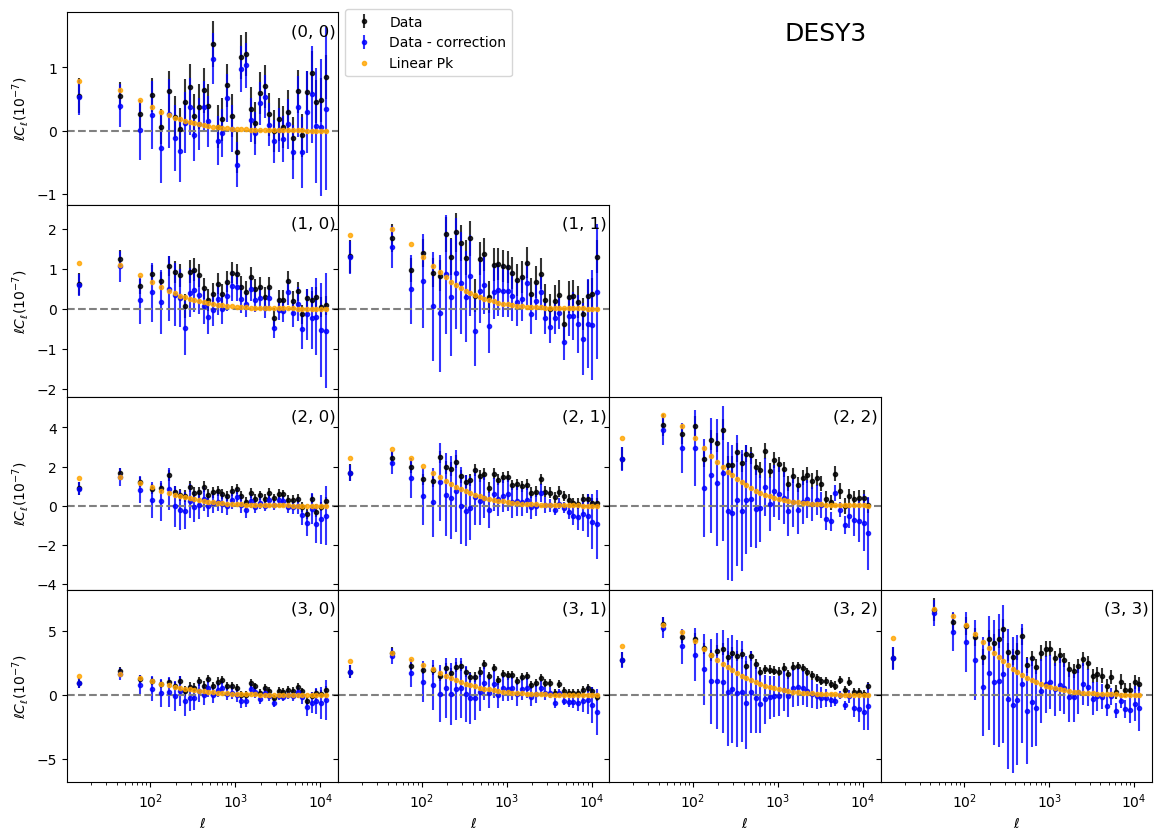

In [34]:
survey = 'DESY3'
nbin = 4


cosmo = ccl.CosmologyVanillaLCDM(matter_power_spectrum='linear')
ccl_tracers = {}
for trn, trv in s.tracers.items():
    ccl_tracers[trn] = ccl.WeakLensingTracer(cosmo, dndz=(trv.z, trv.nz), has_shear=True, ia_bias=None)


f, ax = plt.subplots(nbin, nbin, figsize=(14, 10), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = s.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='Data', alpha=0.8)    

    # BF No-Baryons
    ell, cl, cov, ind = snew.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='blue', label='Data - correction', alpha=0.8)

    # Linear Cell
    ind = s.indices(tracers=('DESY3wl__3', 'DESY3wl__3'))
    bpw = s.get_bandpower_windows(ind)
    cl = (1+m_wl[trs[0]]) * (1+m_wl[trs[1]]) * ccl.angular_cl(cosmo, ccl_tracers[trs[0]], ccl_tracers[trs[1]], bpw.values)
    cl_bin =  bpw.weight.T.dot(cl)
    ax[i, j].errorbar(ell, ell * cl_bin * 1e7, fmt='.', color='orange', label='Linear Pk', alpha=0.8)

    t = ax[i, j].text(0.99, 0.94, f'({i}, {j})', horizontalalignment='right',
                      verticalalignment='top', transform=ax[i, j].transAxes, fontsize=12) 
    ax[i, j].axhline(0, ls='--', color='gray')
    
    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))

plt.show()
plt.close()
